동일한 음악 조각의 호환 가능한 표현을 시간적으로 정렬하는 것이 목표이다. 이 시나리오를 고려하여 음악적 정보를 제공하는 오디오 피쳐(feature)의 필요성을 설명한다. 특히 하모니와 멜로디와 관련된 속성을 포착하는 크로마 기반 음악 피쳐의 개념을 소개한다.

1. log-frequency spectrogram and chromagram
2. log compression
3. feature normalization
4. feature smoothing and downsampling
5. transposition and tuning

In [56]:
import numpy as np
import pandas as pd

import scipy
from scipy import signal
from scipy.interpolate import interp1d

import matplotlib
import matplotlib.pyplot as plt
import librosa, librosa.display
import IPython.display as ipd
from IPython.display import Image

from utils.plot_tools import plot_chromagram
from utils.stft_tools import stft_convention_fmp, compute_f_coef_log

# 로그-주파수 스펙트로그램과 크로마그램 (Log-Frequency Spectrogram and Chromagram)

## STFT와 피치(pitch) 주파수

- 평균율(equal-tempered scale)에 따라 피치를 의미 있게 분류할 수 있는 음악을 다루고 있다고 가정하고, 오디오 녹음이 다양한 피치에 걸쳐 신호 에너지의 분포를 나타내는 피쳐 표현(feautre representation)으로 변환될 수 있는 방법을 보자. 
- 이러한 피쳐(feature)는 선형 주파수 축(Hertz로 측정)을 로그 축(피치로 측정)으로 변환하여 스펙트로그램에서 얻을 수 있다. 이 결과를 **로그 주파수 스펙트로그램(log-frequency spectrogram)** 이라고도 한다.

- 시작하기 앞서 이산 STFT가 필요하다. $x$를 헤르츠로 주어진 고정 샘플링 속도 $F_\mathrm{s}$에 대해 등거리(equidistant) 샘플링으로 얻은 실수 값 이산 신호라고 하자. 또한, $\mathcal{X}$를 길이 $N\in\mathbb{N}$ 및 홉(hop) 크기 $H\in\mathbb{N}$의 윈도우 $w$에 대한 이산 STFT라고 하자. 
- 제로-패딩을 적용하면 푸리에 계수 $\mathcal{X}(n,k)$가 프레임 파라미터 $n\in\mathbb{Z}$와 주파수 파라미터 $k\in[0: K]$로 인덱싱된다. 여기서 $K=N/2$는 Nyquist 주파수에 해당하는 주파수 인덱스이다.

- 각 푸리에 계수 $\mathcal{X}(n,k)$는 초 단위로 주어진 물리적 시간 위치 $T_\mathrm{coef}(n) = nH/F_\mathrm{s}$와 연관되어 있다.
    - $ F_\mathrm{coef}(k) = \frac{k \cdot F_\mathrm{s}}{N} $

- 로그 주파수 스펙트로그램의 주요 아이디어는 평균율 스케일의 로그 간격 주파수 분포에 해당하도록 주파수 축을 재정의하는 것이다. MIDI 음표 번호로 피치를 식별하면(음표 A4는 MIDI 음표 번호 $p=69$에 해당), 중심 주파수는 다음과 같이 지정된다:
    - $ F_\mathrm{pitch}(p) = 2^{(p-69)/12} \cdot 440. $

- 예를 들어 피아노 연주 반음계(chromatic scale)를 고려해보자. 결과의 스펙트로그램은 연주된 음의 피치에 대한 기본 주파수(fundamental frequency)의 기하급수적 종속성(exponential dependency)을 나타낸다. 또한 화음과 음의 시작(onset) 위치(수직 구조)가 명확하게 표시된다.

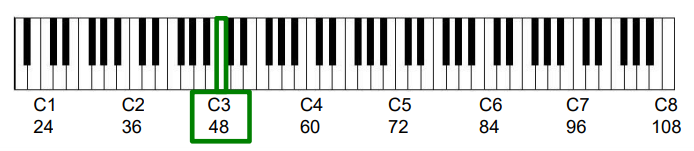

In [3]:
Image("../img/4.music_synchronization/f.4.1a.png", width=400)

In [4]:
# 위와 다를 수 있음
ipd.Audio("../audio/piano_chromatic.wav")

In [6]:
# Load wav
x, Fs = librosa.load("../audio/piano_chromatic.wav")

# Compute Magnitude STFT
N = 4096
H = 1024
Y, T_coef, F_coef = stft_convention_fmp(x, Fs, N, H, mag=True)
# Y = np.abs(Y) ** 2 (if mag=False)

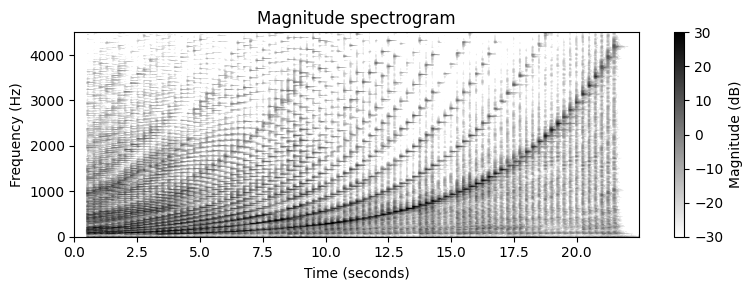

In [7]:
# Plot spectrogram
fig = plt.figure(figsize=(8, 3))
eps = np.finfo(float).eps
plt.imshow(10 * np.log10(eps + Y), origin='lower', aspect='auto', cmap='gray_r', 
           extent=[T_coef[0], T_coef[-1], F_coef[0], F_coef[-1]])
plt.title("Magnitude spectrogram")
plt.clim([-30, 30])
plt.ylim([0, 4500])
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')
cbar = plt.colorbar()
cbar.set_label('Magnitude (dB)')
plt.tight_layout()

## 로그 주파수 풀링 (Logarithmic Frequency Pooling)

- 주파수에 대한 로그 인식은 평균율 음계의 피치로 레이블이 지정된 로그 주파수 축으로 시간-주파수 표현을 사용하도록 한다. 
- 주어진 스펙트로그램에서 그러한 표현을 도출하기 위한 기본 아이디어로는 각 스펙트럼 계수(sprectral coefficient) $\mathcal{X}(n,k)$를 주파수 $F_\mathrm{coef}(k)$에 가장 가까운 중심 주파수의 피치에 할당하는 것이다.
- 보다 정확하게는 각 피치 $p\in[0:127]$에 대해 다음의 집합을 정의한다.
\begin{equation}
    P(p) := \{k:F_\mathrm{pitch}(p-0.5) \leq   F_\mathrm{coef}(k) <  F_\mathrm{pitch}(p+0.5)\}.
\end{equation}

- $P(p)$에 포함되는 주파수 범위는 **로그** 방식의 주파수에 따라 달라진다. 피치 $p$의 **대역폭(bandwidth)** $\mathrm{BW}(p)$를 다음과 같이 정의한다.

\begin{equation}
      \mathrm{BW}(p):=F_\mathrm{pitch}(p+0.5)-F_\mathrm{pitch}(p-0.5).
\end{equation}

- 대역폭 $\mathrm{BW}(p)$는 피치가 낮아질수록 작아진다. 특히 피치를 한 옥타브 내리면 반으로 감소한다. 예를 들어, MIDI 피치 $p=66$의 경우 대역폭은 대략 $21.4~\mathrm{Hz}$인 반면 $p=54$의 경우 대역폭은 $10.7~\mathrm{Hz}$ 아래로 떨어진다. 다음 표는 다양한 음표와 MIDI 음표 번호 $p$, 중심 주파수 $F_\mathrm{pitch}(p)$, 컷오프(cutoff) 주파수 $F_\mathrm{pitch}(p-0.5)$ 및 $F_\mathrm{pitch}(p+0.5)$ 및 대역폭 $\mathrm{BW}(p)$을 보여준다.

In [8]:
def note_name(p):
    """Returns note name of pitch

    Args:
        p (int): Pitch value

    Returns:
        name (str): Note name
    """
    chroma = ['A', 'A$^\\sharp$', 'B', 'C', 'C$^\\sharp$', 'D', 'D$^\\sharp$', 'E', 'F', 'F$^\\sharp$', 'G',
              'G$^\\sharp$']
    name = chroma[(p - 69) % 12] + str(p // 12 - 1)
    return name

In [9]:
f_pitch = lambda p: 440 * 2 ** ((p - 69) / 12)
   
note_infos = []
for p in range(60, 73):
    name = note_name(p)
    p_pitch = f_pitch(p)
    p_pitch_lower = f_pitch(p - 0.5)
    p_pitch_upper = f_pitch(p + 0.5)
    bw = p_pitch_upper - p_pitch_lower
    note_infos.append([name, p, p_pitch, p_pitch_lower, p_pitch_upper, bw])

df = pd.DataFrame(note_infos, columns=['Note', '$p$', 
                                       '$F_\mathrm{pitch}(p)$', 
                                       '$F_\mathrm{pitch}(p-0.5)$', 
                                       '$F_\mathrm{pitch}(p+0.5)$', 
                                       '$\mathrm{BW}(p)$'])


html = df.to_html(index=False, float_format='%.2f')
html = html.replace('<table', '<table style="width: 80%"')
ipd.HTML(html)

## 로그-주파수 스펙트로그램 (Log-Frequency Spectrogram)

- 집합 $P(p)$를 기반으로 다음의 간단한 풀링 절차를 사용하여 로그-주파수 스펙트로그램 $\mathcal{Y}_\mathrm{LF}:\mathbb{Z}\times [0:127]$를 얻는다.
\begin{equation}
      \mathcal{Y}_\mathrm{LF}(n,p) := \sum_{k \in P(p)}{|\mathcal{X}(n,k)|^2}.
\end{equation}

- 이 절차에 따라 주파수 축은 로그적으로 분할되고 MIDI 피치에 따라 선형으로 레이블이 지정된다.

In [10]:
def f_pitch(p, pitch_ref=69, freq_ref=440.0):
    """Computes the center frequency/ies of a MIDI pitch

    Args:
        p (float): MIDI pitch value(s)
        pitch_ref (float): Reference pitch (default: 69)
        freq_ref (float): Frequency of reference pitch (default: 440.0)

    Returns:
        freqs (float): Frequency value(s)
    """
    return 2 ** ((p - pitch_ref) / 12) * freq_ref


def pool_pitch(p, Fs, N, pitch_ref=69, freq_ref=440.0):
    """Computes the set of frequency indices that are assigned to a given pitch
    
    Args:
        p (float): MIDI pitch value
        Fs (scalar): Sampling rate
        N (int): Window size of Fourier fransform
        pitch_ref (float): Reference pitch (default: 69)
        freq_ref (float): Frequency of reference pitch (default: 440.0)

    Returns:
        k (np.ndarray): Set of frequency indices
    """
    lower = f_pitch(p - 0.5, pitch_ref, freq_ref)
    upper = f_pitch(p + 0.5, pitch_ref, freq_ref)
    k = np.arange(N // 2 + 1)
    k_freq = k * Fs / N  # F_coef(k, Fs, N)
    mask = np.logical_and(lower <= k_freq, k_freq < upper)
    return k[mask]


def compute_spec_log_freq(Y, Fs, N):
    """Computes a log-frequency spectrogram

    Args:
        Y (np.ndarray): Magnitude or power spectrogram
        Fs (scalar): Sampling rate
        N (int): Window size of Fourier fransform

    Returns:
        Y_LF (np.ndarray): Log-frequency spectrogram
        F_coef_pitch (np.ndarray): Pitch values
    """
    Y_LF = np.zeros((128, Y.shape[1]))
    for p in range(128):
        k = pool_pitch(p, Fs, N)
        Y_LF[p, :] = Y[k, :].sum(axis=0)
    F_coef_pitch = np.arange(128)
    return Y_LF, F_coef_pitch

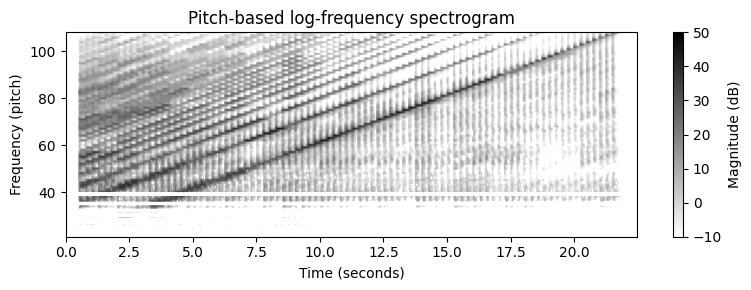

In [11]:
Y_LF, F_coef_pitch = compute_spec_log_freq(Y, Fs, N)        

fig = plt.figure(figsize=(8, 3))
plt.imshow(10 * np.log10(eps + Y_LF), origin='lower', aspect='auto', cmap='gray_r', 
           extent=[T_coef[0], T_coef[-1], 0, 127])
plt.title("Pitch-based log-frequency spectrogram")
plt.clim([-10, 50])
plt.ylim([21, 108])
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (pitch)')
cbar = plt.colorbar()
cbar.set_label('Magnitude (dB)')

plt.tight_layout()

- 스펙트로그램를 보면 다음과 같은 몇 가지 흥미로운 사실을 관찰할 수 있다.

    * 일반적으로 높은 음의 소리는 낮은 음의 소리보다 더 깨끗한 하모닉 스펙트럼을 가진다. 낮은 음의 경우 신호의 에너지가 높은 고조파(harmonic)에 포함되는 경우가 많지만, 청취자는 여전히 낮은 피치의 소리로 인식할 수 있다.

    * 스펙트로그램에 표시된 수직 줄무늬(주파수 축을 따라)는 일부 신호 에너지가 스펙트럼의 큰 부분에 퍼져 있음을 나타낸다. 에너지 확산의 주요 원인은 건반 입력(기계적 소음)으로 인한 피아노 음향의 불협화음과 과도 및 공명 효과 때문이다.

    * 또한 소리의 주파수 내용은 마이크의 주파수 응답에 따라 달라진다. 예를 들어 마이크는 위의 오디오 예제의 경우와 같이 특정 임계값 이상의 주파수만 캡처할 수 있다. 이것은 또한 음 A0($p=21$)에서 B0($p=32$)에 대한 기본 주파수에서 가시적으로 에너지가 거의 없는 이유를 설명할 수 있다.

- 음향적인 속성 외에도 이산 STFT를 기반으로 하는 풀링 전략을 사용할 때 낮은 피치를 제대로 표현하지 못하는 또 다른 이유가 있다. 이산 STFT는 주파수 축의 **선형** 샘플링을 도입하지만 풀링(pooling) 전략에 사용되는 대역폭은 **로그** 방식으로 주파수에 따라 달라진다. 그 결과, 집합 $P(p)$는 매우 적은 수의 스펙트럼 계수만 포함하거나 작은 $p$ 값에 대해서는 비어 있을 수도 있다(위 그림에서 가로 흰색 줄무늬의 이유임).

In [12]:
print('Sampling rate: Fs = ', Fs)
print('Window size: N = ', N)
print('STFT frequency resolution (in Hz): Fs/N = %4.2f' % (Fs / N))

for p in [76, 64, 52, 40, 39, 38]:
    print('Set P(%d) = %s' % (p, pool_pitch(p, Fs, N)))

Sampling rate: Fs =  22050
Window size: N =  4096
STFT frequency resolution (in Hz): Fs/N = 5.38
Set P(76) = [119 120 121 122 123 124 125 126]
Set P(64) = [60 61 62 63]
Set P(52) = [30 31]
Set P(40) = [15]
Set P(39) = []
Set P(38) = [14]


## 크로마그램 (Chromagram)

- 이제 음색(timbre)과 악기에 따른 로그-주파수 스펙트로그램의 견고성을 높이는 전략에 대해 논의해본다. 

- 하나 또는 여러 옥타브 차이의 피치에 해당하는 피치 밴드를 적절하게 결합하는 것이다. 

- 음정에 대한 인간의 인식은 두 음정이 한 옥타브 차이가 나는 경우 "색상"(유사한 하모닉 역할을 함)이 유사한 것으로 인식된다는 점에서 주기적이다. 이 관찰을 기반으로 피치는 톤 높이(tone height)와 크로마(chroma)라고 하는 두 가지 구성 요소로 분리될 수 있다.

- 톤 높이는 다음의 집합에 포함된 각 피치 스펠링 속성에 대한 옥타브 수와 크로마를 나타낸다.
    - $\{\mathrm{C},\mathrm{C}^\sharp,\mathrm{D},\mathrm{D}^\sharp,\ldots,\mathrm{B}\}.$

- 크로마 값을 enumerate하면서 이 집합을 $[0:11]$로 식별할 수 있다. 여기서 $0$는 크로마 $\mathrm{C}$, $1$는 $\mathrm{C}^\sharp$ 등을 나타낸다. **피치 클래스**는 동일한 크로마를 공유하는 모든 피치의 집합으로 정의된다.

- **크로마 피쳐**의 기본 아이디어는 주어진 피치 클래스와 관련된 모든 스펙트럼 정보를 단일 계수로 집계하는 것이다. 피치 기반 로그-주파수 스펙트로그램 $\mathcal{Y}_\mathrm{LF}:\mathbb{Z}\times[0:127]\to \mathbb{R}_{\geq 0}$가 주어지면, **크로마 표현** 또는 **크로마그램** $\mathbb{Z}\times[0:11]\to \mathbb{R}_{\geq 0}$는 다음의 동일한 채도에 속한 모든 피치 계수를 더해 구할 수 있다.
    - $\mathcal{C}(n,c) := \sum_{\{p \in [0:127]\,:\,p\,\mathrm{mod}\,12 = c\}}{\mathcal{ Y}_\mathrm{LF}(n,p)}$ for $c\in[0:11]$.

- 다음 코드 예에서 크로마 피쳐의 순환적(cyclic) 특성을 볼 수 있는 크로마틱 스케일의 크로마그램을 생성한다. 옥타브 등가(equivalence)로 인해 크로마틱 스케일의 증가하는 음은 크로마 축을 둘러싼다(wrapped around). 
- 로그-주파수 스펙트로그램과 마찬가지로 오디오 예제의 결과 크로마그램은 특히 낮은 음에 대해 노이즈가 많다. 게다가 고조파가 존재하기 때문에 에너지는 일반적으로 한 번에 하나의 음을 연주할 때에도 다양한 크로마 밴드에 분산된다. 
- 예를 들어 C3 음표를 연주하면 세 번째 배음(harmonic)은 G4에 해당하고 다섯 번째 배음은 E5에 해당한다. 따라서 C3음을 피아노로 연주할 때 크로마 밴드 $\mathrm{C}$뿐만 아니라 크로마 밴드 $\mathrm{G}$ 및 $\mathrm{E}$도 신호의 에너지의 상당한 부분을 포함하고 있다. 

In [13]:
def compute_chromagram(Y_LF):
    """Computes a chromagram
    
    Args:
        Y_LF (np.ndarray): Log-frequency spectrogram

    Returns:
        C (np.ndarray): Chromagram
    """
    C = np.zeros((12, Y_LF.shape[1]))
    p = np.arange(128)
    for c in range(12):
        mask = (p % 12) == c
        C[c, :] = Y_LF[mask, :].sum(axis=0)
    return C

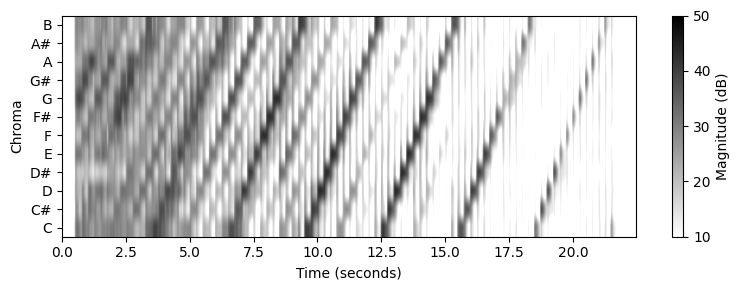

In [14]:
C = compute_chromagram(Y_LF)

fig = plt.figure(figsize=(8, 3))
chroma_label = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
plt.imshow(10 * np.log10(eps + C), origin='lower', aspect='auto', cmap='gray_r', 
           extent=[T_coef[0], T_coef[-1], 0, 12])
plt.clim([10, 50])
plt.xlabel('Time (seconds)')
plt.ylabel('Chroma')
cbar = plt.colorbar()
cbar.set_label('Magnitude (dB)')
plt.yticks(np.arange(12) + 0.5, chroma_label)
plt.tight_layout()

In [15]:
x, Fs = librosa.load("../audio/beeth5_piano_21bars.wav")
ipd.display(ipd.Audio(x, rate=Fs))

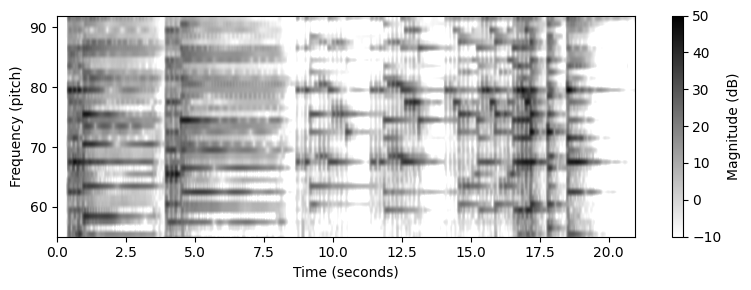

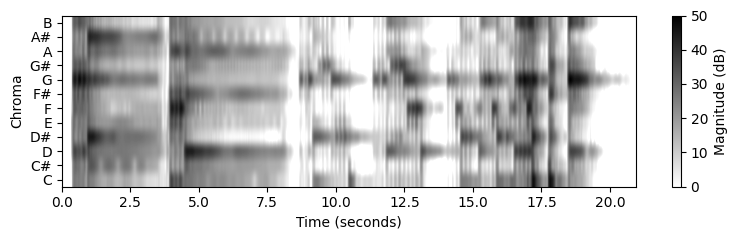

In [16]:
N = 4096
H = 512
X, T_coef, F_coef = stft_convention_fmp(x, Fs, N, H)
eps = np.finfo(float).eps
Y = np.abs(X) ** 2
Y_LF, F_coef_pitch = compute_spec_log_freq(Y, Fs, N)
C = compute_chromagram(Y_LF)

fig = plt.figure(figsize=(8,3))
plt.imshow(10 * np.log10(eps + Y_LF), origin='lower', aspect='auto', cmap='gray_r', 
           extent=[T_coef[0], T_coef[-1], 0, 128])
plt.clim([-10, 50])
plt.ylim([55, 92])
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (pitch)')
cbar = plt.colorbar()
cbar.set_label('Magnitude (dB)')
plt.tight_layout()

fig = plt.figure(figsize=(8, 2.5))
plt.imshow(10 * np.log10(eps + C), origin='lower', aspect='auto', cmap='gray_r', 
           extent=[T_coef[0], T_coef[-1], 0, 12])
plt.clim([0, 50])
plt.xlabel('Time (seconds)')
plt.ylabel('Chroma')
cbar = plt.colorbar()
cbar.set_label('Magnitude (dB)')
plt.yticks(np.arange(12) + 0.5, chroma_label)
plt.tight_layout()

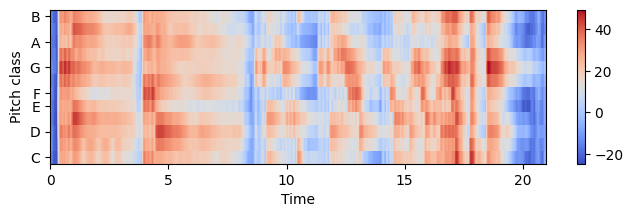

In [17]:
#librosa example 
N = 4096
H = 512
x, Fs = librosa.load("../audio/beeth5_piano_21bars.wav")
C = librosa.feature.chroma_stft(y=x, tuning=0, norm=None, hop_length=H, n_fft=N)
plt.figure(figsize=(8, 2))
librosa.display.specshow(10 * np.log10(eps + C), x_axis='time', 
                         y_axis='chroma', sr=Fs, hop_length=H)
plt.colorbar();

# 로그 컴프레션/압축 (Logarithmic Compression)

## 컴프레션 함수 (Compression Function)

- 음악 신호 처리에서 스펙트로그램이나 크로마그램의 문제는 그 값이 큰 동적 범위(dynamic range)를 갖는다는 것이다. 결과적으로 작지만 여전히 관련성이 높은 값이 큰 값에 의해 가려질 수 있다. 따라서 **데시벨 단위 (decibel scale)** 를 사용하는 경우가 많다. 큰 값과 작은 값의 차이를 줄이고 작은 값을 향상시키는 효과로 이러한 불일치의 균형을 맞추는 것이다. 보다 일반적으로 **로그 압축**이라고 하는 단계인 다른 유형의 로그-기반 함수를 적용할 수 있습니다.

- $\gamma\in\mathbb{R}_{>0}$를 양의 상수로 두고, 다음과 같이 함수 $\Gamma_\gamma:\mathbb{R}_{>0} \to \mathbb{R}_{>0}$를 정의할 수 있다. 
    - $\Gamma_\gamma(v):=\log(1+ \gamma \cdot v)$ for some positive value $v\in\mathbb{R}_{>0}$

- $\mathrm{dB}$ 함수와 달리 $\Gamma_\gamma$ 함수는 모든 양수 값 $v\in\mathbb{R}_{>0}$에 대해 양수 값 $\Gamma_\gamma(v)$를 생성한다. 
- 컴프레션 정도는 상수 $\gamma$로 조정할 수 있다. $\gamma$가 클수록 컴프레션이 커진다.

In [18]:
def log_compression(v, gamma=1.0):
    """Logarithmically compresses a value or array

    Args:
        v (float or np.ndarray): Value or array
        gamma (float): Compression factor (Default value = 1.0)

    Returns:
        v_compressed (float or np.ndarray): Compressed value or array
    """
    return np.log(1 + gamma * v)

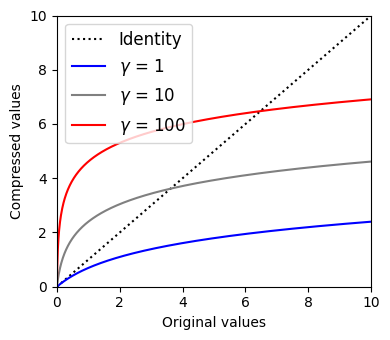

In [19]:
v = np.arange(1001) / 100

plt.figure(figsize=(4, 3.5))
plt.plot(v, v, color='black', linestyle=':', label='Identity')
plt.plot(v, log_compression(v, gamma=1), color='blue', label='$\gamma$ = 1')
plt.plot(v, log_compression(v, gamma=10), color='gray', label='$\gamma$ = 10')
plt.plot(v, log_compression(v, gamma=100), color='red', label='$\gamma$ = 100')
plt.xlabel('Original values')
plt.ylabel('Compressed values')
plt.xlim([v[0], v[-1]])
plt.ylim([v[0], v[-1]])
# plt.tick_params(direction='in')
plt.legend(loc='upper left', fontsize=12)
plt.tight_layout()

## 압축된 스펙트로그램 (Compressed Spectrogram)

- 스펙트로그램과 같은 양수 값을 가진 표현의 경우 $\Gamma_\gamma$ 함수를 각 값에 적용하여 압축된 버전을 얻는다. 예를 들어, 스펙트로그램 $\mathcal{Y}$의 경우 압축된 버전은 다음과 같이 정의된 concatenation $\Gamma_\gamma \circ \mathcal{Y}$이다.
    - $(\Gamma_\gamma\circ \mathcal{Y})(n,k):=\log(1+ \gamma \cdot \mathcal{Y}(n,k))$

- 여기서 $n$은 시간 프레임 파라미터이고 $k$는 주파수 빈(bin) 파라미터이다. $\gamma$의 적절한 선택은 데이터 특성과 염두에 둔 적용에 따라 크게 달라진다. 특히, 잡음이 있는 경우, 약하지만 관련된 신호 구성 요소를 향상시키는 것과 바람직하지 않은 잡음 구성 요소를 너무 많이 증폭시키지 않는 것 사이에서 적절한 균형을 찾아야 한다. 

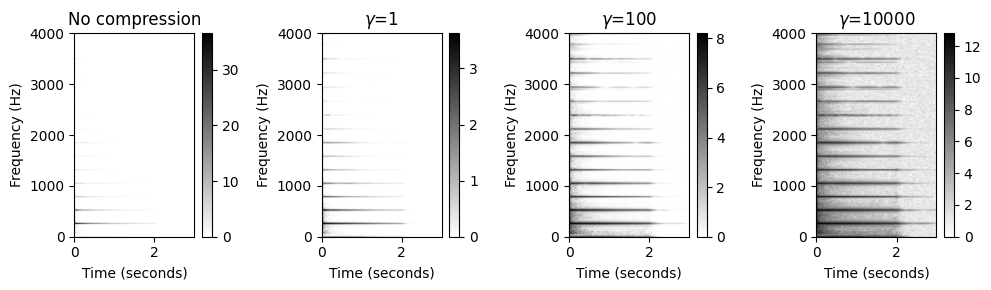

In [20]:
x, Fs = librosa.load("../audio/piano_c4.wav")

N = 2048
H = 512
X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hann', pad_mode='constant', center=True)
T_coef = np.arange(X.shape[1]) * H / Fs
K = N // 2
F_coef = np.arange(K + 1) * Fs / N
Y = np.abs(X) ** 2

plt.figure(figsize=(10, 3))
extent = [T_coef[0], T_coef[-1], F_coef[0], F_coef[-1]]
gamma_set = [0, 1, 100, 10000]
M = len(gamma_set)
Y = np.abs(X)

for m in range(M):
    ax = plt.subplot(1, M, m + 1)
    gamma = gamma_set[m]
    if gamma == 0:
        Y_compressed = Y
        title = 'No compression'
    else:
        Y_compressed = log_compression(Y, gamma=gamma)
        title = '$\gamma$=%d' % gamma
    plt.imshow(Y_compressed, cmap='gray_r', aspect='auto', origin='lower', extent=extent)
    plt.xlabel('Time (seconds)')
    plt.ylim([0, 4000])
    plt.clim([0, Y_compressed.max()])
    plt.ylabel('Frequency (Hz)')
    plt.colorbar()
    plt.title(title)

plt.tight_layout()

- 원본 스펙트로그램에서는 수평선이 거의 보이지 않지만 압축된 버전에서는 명확하게 나타난다. 단점으로는 스펙트로그램을 압축할 때 잡음과 같은 사운드 구성 요소도 향상된다는 것이다. 잡음이 있는 경우, 약하지만 관련된 신호 구성 요소를 강화하는 것과 바람직하지 않은 잡음 구성 요소를 너무 많이 증폭하지 않는 것 사이에서 적절한 균형을 찾아야 한다.

## 압축된 크로마그램 (Compressed Chromagram)

- 다음으로 chromagram $\mathcal{C}$ 및 압축 버전 $\Gamma_\gamma \circ \mathcal{C}$를 생각해보자.
    - $(\Gamma_\gamma\circ \mathcal{C})(n,c):=\log(1+ \gamma \cdot \mathcal{C}(n,c))$

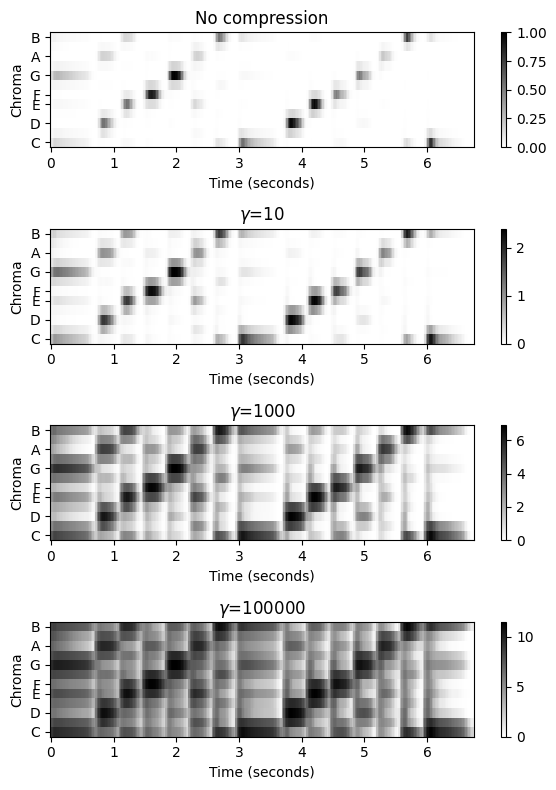

In [21]:
x, Fs = librosa.load("../audio/piano_c_scale.wav")

N = 4096
H = 512
C = librosa.feature.chroma_stft(y=x, tuning=0, norm=None, hop_length=H, n_fft=N)
C = C / C.max()

plt.figure(figsize=(6, 8))
gamma_set = [0, 10, 1000, 100000]
M = len(gamma_set)
Y = np.abs(X)

for m in range(M):
    ax = plt.subplot(M, 1, m + 1)
    gamma = gamma_set[m]
    if gamma == 0:
        C_compressed = C
        title = 'No compression'
    else:
        C_compressed = log_compression(C, gamma=gamma)
        title = '$\gamma$=%d' % gamma
    librosa.display.specshow(C_compressed, x_axis='time', 
                             y_axis='chroma', cmap='gray_r', sr=Fs, hop_length=H)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Chroma')
    plt.clim([0, np.max(C_compressed)])
    plt.title(title)
    plt.colorbar()

plt.tight_layout()

# 피쳐 정규화 (Feature Normalization)

## Norm 

- 여태까지 스펙트럼 피쳐(spectral features), 로그-주파수 스펙트럼 피쳐 및 크로마 피쳐(chroma feautres)를 비롯한 다양한 기능 표현을 소개했다. 이러한 피쳐는 일반적으로 어떤 차원 $K\in\mathbb{N}$의 유클리드 공간의 요소이다. 
- 앞으로 이 **피쳐 공간**을 $\mathcal{F}=\mathbb{R}^K$로 표시한다. 종종 피처에 크기나 일종의 길이를 할당하는 측정이 필요하며, 이는 **norm**이라는 개념으로 이어진다. 수학 용어로 벡터 공간(예: $\mathcal{F}=\mathbb{R}^K$)이 주어지면 norm은 다음의 세 가지 속성을 만족하는 음이 아닌 함수 $p:\mathcal{F} \to \mathbb{R}_{\geq 0}$이다:

    * Triangle inequality: $p(x + y) \leq p(x) + p(y)$ for all $x,y\in\mathcal{F}$.

    * Positive scalability: $p(\alpha x) = |\alpha| p(x)$ for all $x\in\mathcal{F}$ and $\alpha\in\mathbb{R}$. 

    * Positive definiteness: $p(x) = 0$ if an only if $x=0$.

- 벡터 $x\in\mathcal{F}$에 대한 숫자 $p(x)$를 벡터의 **길이**라고 한다. 또한 $p(x)=1$인 벡터를 **단위 벡터**라고 한다. 
- 여러 norm이 있음에 유의하자. 다음에서는 벡터 공간 $\mathcal{F}=\mathbb{R}^K$만 고려하고, 세 가지 norm을 살펴보자.

### 유클리드 (Euclidean) Norm

- 가장 보편적인 것은 **Euclidean norm** (or $\ell^2$-norm)이다. 이 norm은 $\|\cdot\|_2$로 표기되며 다음과 같이 정의할 수 있다.
    - $ \|x\|_2 = \sqrt{\langle x\mid x\rangle} = \Big(\sum_{k=1}^K x(k)^2\Big)^{1/2}$
    - for a vector $x=(x(1),x(2),\ldots,x(K))^\top \in\mathbb{R}^K$.  

- 유클리드 norm $\|x\|_2$는 원점 $(0,0)$에서 점 $x$까지의 일반적인 거리를 나타낸다. 
- 유클리드 norm에 관한 단위 벡터 집합은 $S^{K-1}\subset\mathbb{R}^K$로 표시되는 **단위 구(unit sphere)** 를 형성한다. 
- $K=2$인 경우 단위구는 원점이 $(0,0)$인 단위원(unit circle) $S^1$이다.

In [22]:
def plot_vector(x,y, color='k', start=0, linestyle='-'):    
    return plt.arrow(np.real(start), np.imag(start), x, y, 
                     linestyle=linestyle, head_width=0.05, 
                     fc=color, ec=color, overhang=0.3, length_includes_head=True)

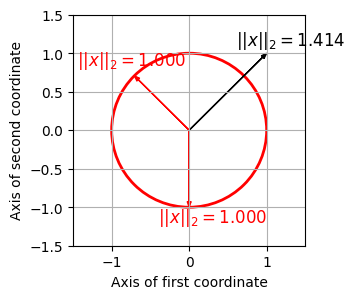

In [23]:
def norm_Euclidean(x):
    p = np.sqrt(np.sum(x ** 2))
    return p

fig, ax = plt.subplots(figsize=(3, 3))
plt.grid()  
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])
plt.xlabel('Axis of first coordinate')
plt.ylabel('Axis of second coordinate')

circle = plt.Circle((0, 0), 1, color='r', fill=0, linewidth=2)  
ax.add_artist(circle)

x_list = [np.array([[1, 1], [0.6, 1.1]]),
          np.array([[-np.sqrt(2)/2, np.sqrt(2)/2], [-1.45, 0.85]]),
          np.array([[0, -1], [-0.4, -1.2]])]

for y in x_list:
    x = y[0, :]
    p = norm_Euclidean(x)
    color = 'r' if p == 1 else 'k'
    plot_vector(x[0], x[1], color=color)
    plt.text(y[1, 0], y[1, 1], r'$||x||_2=%0.3f$'% p, size='12', color=color) 

### 맨해튼 (Manhattan) Norm

- **Manhattan norm** (or $\ell^1$-norm)에서 벡터의 길이는 벡터의 데카르트 좌표의 절대값을 합산하여 측정된다. 맨해튼 norm ($\|\cdot\|_1$)은 다음과 같이 정의된다,
    - $ \|x\|_1 = \sum_{k=1}^K |x(k)|$
    - for a vector $x=(x(1),x(2),\ldots,x(K))^\top \in\mathbb{R}^K$. 
- 맨해튼 norm에서 단위 벡터 집합은 좌표축에 대해 45도 각도로 향하는 면이 있는 정사각형을 형성한다. $K=2$인 경우 단위원은 $|x(1)| + |x(2)| = 1$로 설명된다.

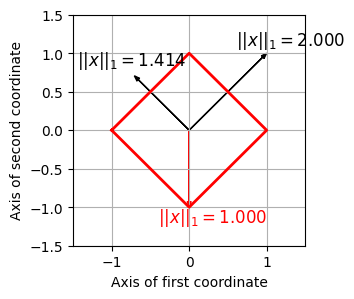

In [24]:
def norm_Manhattan(x):
    p = np.sum(np.abs(x))
    return p
    
fig, ax = plt.subplots(figsize=(3, 3))
plt.grid()  
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])
plt.xlabel('Axis of first coordinate')
plt.ylabel('Axis of second coordinate')

plt.plot([-1, 0, 1, 0, -1], [0, 1, 0, -1, 0], color='r', linewidth=2)

for y in x_list:
    x = y[0, :]
    p = norm_Manhattan(x)
    color = 'r' if p == 1 else 'k'
    plot_vector(x[0], x[1], color=color)
    plt.text(y[1, 0], y[1, 1], r'$||x||_1=%0.3f$' % p, size='12', color=color)

### Maximum Norm

- **maximum norm** (or $\ell^\infty$-norm)에서, 벡터의 길이는 최대 절대 데카르트 좌표로 측정된다. maximum norm ($\|\cdot\|_\infty$)은 다음과 같이 정의된다.
    - $\|x\|_\infty = \max\big\{|x(k)| \,\,\mathrm{for}\,\, k\in[1:K] \big\}$
    - for a vector $x=(x(1),x(2),\ldots,x(K))^\top \in\mathbb{R}^K$. 
    
- 단위 벡터 집합은 가장자리 길이가 2인 hypercube의 표면을 형성한다.

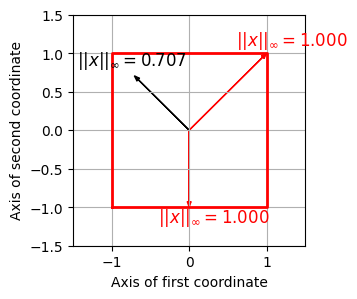

In [25]:
def norm_max(x):
    p = np.max(np.abs(x))
    return p
    
fig, ax = plt.subplots(figsize=(3, 3))
plt.grid()  
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])
plt.xlabel('Axis of first coordinate')
plt.ylabel('Axis of second coordinate')

plt.plot([-1, -1, 1, 1, -1], [-1, 1, 1, -1, -1], color='r', linewidth=2)

for y in x_list:
    x = y[0, :]
    p = norm_max(x)
    color = 'r' if p == 1 else 'k'
    plot_vector(x[0], x[1], color=color)
    plt.text(y[1, 0], y[1, 1], r'$||x||_\infty=%0.3f$' % p, size='12', color=color)

## Feature Normalization

- 음악 처리에서 오디오 녹음은 일반적으로 feature 표현으로 변환된다. feature 표현은 $n\in[1:N]$에 대한 feature 벡터 $x_n \in \mathcal{F}=\mathbb{R}^K$가 있는 sequence $X=(x_1,x_2,\ldots x_N)$로 종종 구성된다.
- feature 표현을 더 잘 비교하기 위해 종종 **정규화(normalization)**를 적용한다. 
- 한 가지 정규화 전략은 적절한 norm $p$를 선택한 다음 각 feature 벡터 $x_n\in\mathcal{F}$를 $x_n/p(x_n)$로 바꾸는 것이다. 이 전략은 $x_n$이 0이 아닌 벡터인 한 작동한다. 정규화된 feature 벡터 $x_n/p(x_n)$는 norm $p$에 대한 단위 벡터이다.

- 예를 들어 $X=(x_1,x_2,\ldots x_N)$가 chroma feature의 시퀀스인 경우를 생각해보자. 이 경우 feature 공간 $\mathcal{F}=\mathbb{R}^K$의 차원은 $K=12$이다. 위에서 설명한 정규화 절차는 각 chroma 벡터를 정규화된 버전으로 대체한다. 
- 결과적으로 정규화된 chroma 벡터는 12개의 chroma 계수 크기의 **절대** 차이가 아닌 **상대**만 차이만 인코딩한다. 직관적으로 말하면, 정규화는 **다이나믹(dynamics)** 또는 **사운드 강도(sound intensity)** 의 차이에 일종의 **불변성(invariance)** 을 도입한다.

- 정규화 절차는 $p(x)\not= 0$인 경우에만 가능하다. 실제 녹음 시작 전이나 긴 일시 중지 중에 무음 구간에서 발생할 수 있는 매우 작은 $p(x)$ 값에 대해 정규화 할 시 다소 무작위적이고 무의미한 크로마 값 분포로 이어질 수 있다. 
- 따라서 $p(x)$가 특정 임계값 아래로 떨어지면, $p(x)$로 나누는 대신 $x$ 벡터를  norm 1의 uniform 벡터와 같은 표준(standard) 벡터로 대체할 수 있다.

- 수학적으로 이 정규화 절차는 다음과 같이 설명할 수 있다. 
- $S^{K-1}\subset\mathbb{R}^{K}$를 norm 1의 모든 K-차원 벡터를 포함하는 단위 구라고 하자. 그런 다음 주어진 임계값 $\varepsilon>0$에 대해 프로젝션 연산자 $\pi^{\varepsilon}:\mathbb{R}^{K}\to S^{K-1}$를 다음과 같이 정의한다.
\begin{equation}
\pi^{\varepsilon}(x):=
\left\{\begin{array}{cl} x / p(x) & \,\,\,\mbox{if}\,\, p(x) > \varepsilon\\
          u & \,\,\,\mbox{if}\,\, p(x) \leq \varepsilon \end{array}\right.
\end{equation}
where $u=v/p(v)$ is the unit vector of the all-one vector $v=(1,1,\ldots,1)^\top\in\mathbb{R}^K$

- 이 연산자를 기반으로 각 chroma 벡터 $x$는 $\pi^{\varepsilon}(x)$로 대체될 수 있다. 
- $\varepsilon$ 임계값은 신중하게 선택해야 하는 파라미터이다. 응용에 따라 적절한 값을 선택해야 한다. 
- 정규화에 대한 많은 변형도 생각할 수 있다. 분명히 정규화는 선택한 norm과 임계값에 따라 달라진다. 또한 균등하게 분산된 단위 벡터 $u$를 사용하는 대신, 작은 크기의 feature 벡터를 나타내는 다른 벡터를 사용할 수도 있다.

In [26]:
def normalize_feature_sequence(X, norm='2', threshold=0.0001, v=None):
    """Normalizes the columns of a feature sequence

    Args:
        X (np.ndarray): Feature sequence
        norm (str): The norm to be applied. '1', '2', 'max' or 'z' (Default value = '2')
        threshold (float): An threshold below which the vector ``v`` used instead of normalization
            (Default value = 0.0001)
        v (float): Used instead of normalization below ``threshold``. If None, uses unit vector for given norm
            (Default value = None)

    Returns:
        X_norm (np.ndarray): Normalized feature sequence
    """
    assert norm in ['1', '2', 'max', 'z']

    K, N = X.shape
    X_norm = np.zeros((K, N))

    if norm == '1':
        if v is None:
            v = np.ones(K, dtype=np.float64) / K
        for n in range(N):
            s = np.sum(np.abs(X[:, n]))
            if s > threshold:
                X_norm[:, n] = X[:, n] / s
            else:
                X_norm[:, n] = v

    if norm == '2':
        if v is None:
            v = np.ones(K, dtype=np.float64) / np.sqrt(K)
        for n in range(N):
            s = np.sqrt(np.sum(X[:, n] ** 2))
            if s > threshold:
                X_norm[:, n] = X[:, n] / s
            else:
                X_norm[:, n] = v

    if norm == 'max':
        if v is None:
            v = np.ones(K, dtype=np.float64)
        for n in range(N):
            s = np.max(np.abs(X[:, n]))
            if s > threshold:
                X_norm[:, n] = X[:, n] / s
            else:
                X_norm[:, n] = v

    if norm == 'z':
        if v is None:
            v = np.zeros(K, dtype=np.float64)
        for n in range(N):
            mu = np.sum(X[:, n]) / K
            sigma = np.sqrt(np.sum((X[:, n] - mu) ** 2) / (K - 1))
            if sigma > threshold:
                X_norm[:, n] = (X[:, n] - mu) / sigma
            else:
                X_norm[:, n] = v

    return X_norm

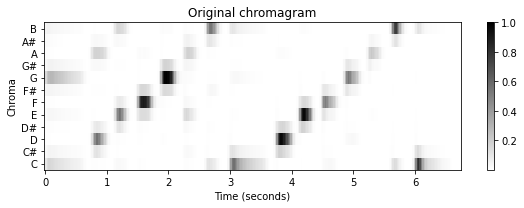

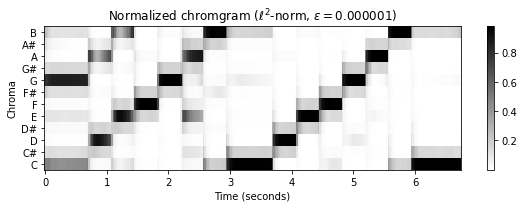

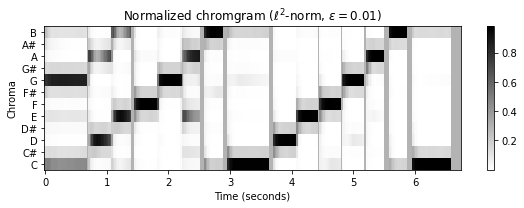

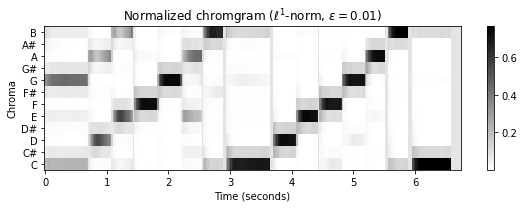

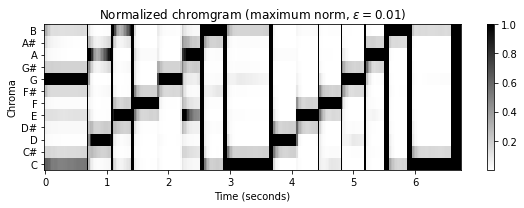

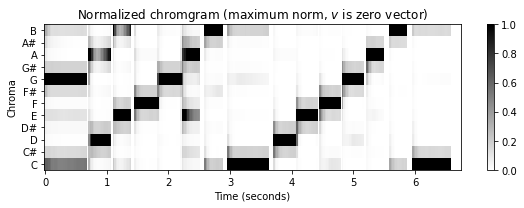

In [27]:
x, Fs = librosa.load("../audio/piano_c_scale.wav")

N, H = 4096, 512
C = librosa.feature.chroma_stft(y=x, sr=Fs, tuning=0, norm=None, hop_length=H, n_fft=N)
C = C / C.max()

figsize=(8, 3)
plot_chromagram(C, Fs=Fs/H, figsize=figsize, title='Original chromagram')

threshold = 0.000001
C_norm = normalize_feature_sequence(C, norm='2', threshold=threshold)
plot_chromagram(C_norm, Fs=Fs/H, figsize=figsize, 
        title = r'Normalized chromgram ($\ell^2$-norm, $\varepsilon=%f$)' % threshold)

threshold = 0.01
C_norm = normalize_feature_sequence(C, norm='2', threshold=threshold)
plot_chromagram(C_norm, Fs=Fs/H, figsize=figsize, 
        title = r'Normalized chromgram ($\ell^2$-norm, $\varepsilon=%0.2f$)' % threshold)

threshold = 0.01
C_norm = normalize_feature_sequence(C, norm='1', threshold=threshold)
plot_chromagram(C_norm, Fs=Fs/H, figsize=figsize, 
        title = r'Normalized chromgram ($\ell^1$-norm, $\varepsilon=%0.2f$)' % threshold)

threshold = 0.01
C_norm = normalize_feature_sequence(C, norm='max', threshold=threshold)
plot_chromagram(C_norm, Fs=Fs/H, figsize=figsize, 
        title = r'Normalized chromgram (maximum norm, $\varepsilon=%0.2f$)' % threshold)

threshold = 0.01
v = np.zeros(C.shape[0])
C_norm = normalize_feature_sequence(C, norm='max', threshold=threshold, v=v)
plot_chromagram(C_norm, Fs=Fs/H, figsize=figsize, 
        title = r'Normalized chromgram (maximum norm, $v$ is zero vector)');

**Standard score**

- feature $x=(x(1),x(2),\ldots,x(K))^\top \in\mathbb{R}^K$의 **평균(mean)** $\mu(x)$ and **분산(variance)** $\sigma(x)$을 사용해 **standard score**를 고려하자.

$$
    z(x) = \frac{x-\mu(x)}{\sigma(x)}.
$$


In [28]:
def normalize_feature_sequence_z(X, threshold=0.0001, v=None):
    K, N = X.shape
    X_norm = np.zeros((K, N))
    
    if v is None:
        v = np.zeros(K)
        
    for n in range(N):
        mu = np.sum(X[:, n]) / K
        sigma = np.sqrt(np.sum((X[:, n] - mu) ** 2) / (K - 1))
        if sigma > threshold:
            X_norm[:, n] = (X[:, n] - mu) / sigma
        else:
            X_norm[:, n] = v  
            
    return X_norm

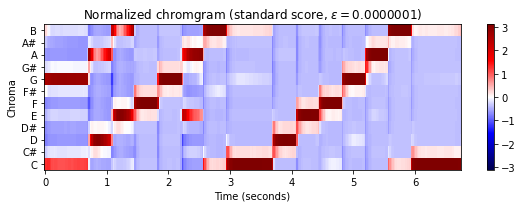

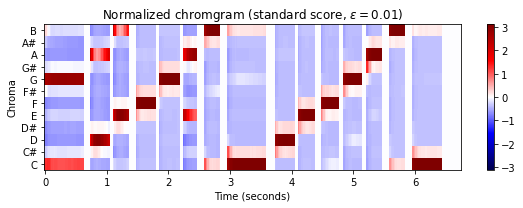

In [29]:
threshold = 0.0000001
C_norm = normalize_feature_sequence_z(C, threshold=threshold)
m = np.max(np.abs(C_norm))
plot_chromagram(C_norm, Fs=Fs/H, figsize=figsize, cmap='seismic', clim=[-m, m],
        title = r'Normalized chromgram (standard score, $\varepsilon=%0.7f$)' % threshold)

threshold = 0.01
C_norm = normalize_feature_sequence_z(C, threshold=threshold)
m = np.max(np.abs(C_norm))
plot_chromagram(C_norm, Fs=Fs/H, figsize=figsize, cmap='seismic', clim=[-m, m],
        title = r'Normalized chromgram (standard score, $\varepsilon=%0.2f$)' % threshold);

# 피쳐 스무싱과 다운샘플링 (Feature Smoothing and Downsampling)

## 예

- 음악 레코딩을 크로마-기반 feature로 변환하는 방법에는 여러 가지가 있다. 예를 들어 푸리에 계수를 적절하게 풀링(pooling)하여 스펙트로그램에서 크로마 feature를 도출하는 방법을 위에 다루었다. 

- 전처리(preprocessing) 및 후처리(postprocessing) 단계를 적용하여 크로마 특징의 속성을 크게 변경할 수 있다. 예를 들어, 추가적인 로그-압축과 정규화 단계를 통해 음색(timbre) 또는 소리 강도(intensity)의 변화(variation)에 대한 견고성을 높일 수 있음을 확인했다. 

- 이 챕터에서는 로컬 템포(local tempo), 아티큘레이션(articulation) 및 음표 실행(note execution)과 같은 측면의 변화에 대해 feature 시퀀스를 보다 견고하게 만드는 데 사용할 수 있는 추가적 후처리 기술을 연구한다.

- 다음 그림은 이러한 성능에 대한 크로마 기반 feature을 보여준다. 크로마그램은 유클리드 norm에 따라 정규화된다. 서로 다른 해석에 따라 아티큘레이션 및 계측에서 상당한 차이를 나타내더라도, 크로마그램은 시간이 지남에 따라 유사한 크로마 분포 진행을 보여준다.

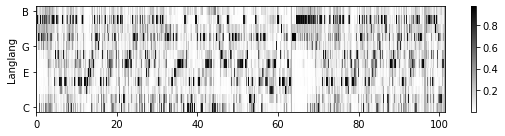

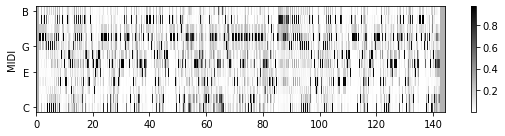

In [30]:
fn_wav_dict = {}
fn_wav_dict['Langlang'] = "../audio/chopin_waltz_langlang.wav"
fn_wav_dict['MIDI'] = "../audio/chopin_waltz_midi.wav"

N, H = 2048, 1024
figsize = (8, 2)
yticks = [0, 4, 7, 11]

C_dict = {}
for name in fn_wav_dict:
    fn_wav = fn_wav_dict[name] 
    x, Fs = librosa.load(fn_wav)
    C = librosa.feature.chroma_stft(y=x, sr=Fs, tuning=0, norm=None, hop_length=H, n_fft=N)
    Fs_C = Fs / H
    C = C / C.max()
    threshold = 0.0001
    C_dict[name] = normalize_feature_sequence(C, norm='2', threshold=threshold)
    plot_chromagram(C_dict[name], Fs_C, figsize=figsize, ylabel=name, xlabel='', chroma_yticks=yticks)

## 시간 평활화와 다운샘플링 Temporal Smoothing and Downsampling

- 특정 음악 검색 응용의 경우 이러한 크로마그램이 너무 상세할 수 있다. 특히 이들 간의 유사도를 더욱 높이는 것이 바람직할 수 있다. 이제 후처리 단계에서 적용되는 **스무딩 절차**를 통해 이것이 어떻게 달성될 수 있는지 보자. 시간이 지남에 따라 각 크로마 차원에 대해 일종의 로컬 평균을 계산한다. 보다 정확하게는, $X=(x_1,x_2, ..., x_N)$를 $x_n\in\mathbb{R}^K$ for $n\in[1:N]$인 피쳐 시퀀스라고 하고, $w$는 $L\in\mathbb{N}$ 길이의 직사각형 윈도우(rectangular window)라고 하자. 그런 다음 각 $k\in[1:K]$에 대해 $w$와 시퀀스 $(x_1(k), x_2(k),\ldots, x_N(k))$ 사이의 convolution을 계산한다. centered view를 가정하면 convolution의 길이 $N$의 중앙 부분만 유지한다. 결과는 동일한 차원 $K\times N$의 평활화된 피쳐 시퀀스이다.

* 다음에서 `scipy.signal.convolve` 함수를 사용하여 2D 컨볼루션을 계산한다. **윈도우**(**커널**이라고도 함)에 대해 차원을 $1\times L$로 설정하면 대역별(bandwise) 1D 컨벌루션이 생성된다.
* `mode='same'` 파라미터를 사용하면 중앙 보기(centered view)가 적용된다.
* 윈도우 $w$는 **Hann 윈도우**와 같은 다른 윈도우 유형을 사용할 수도 있다.

- 직사각형 winodw 또는 Hann window을 사용하여 시간 평활화를 적용하는 것은 feature 표현에서 빠른 시간 변동을 감쇠시키는 대역 **저역 통과 필터링 (lowpass filtering)** 으로 간주될 수 있다. 
- 종종 후속 처리 및 분석 단계의 효율성을 높이기 위해, 모든 $H^\mathrm{th}$ 피쳐만 유지하여 평활화된 표현을 단순화(decimation)하며, 여기서 $H\in\mathbb{N}$는 적절한 상수(일반적으로 창 길이 $L$보다 훨씬 작음)이다. **다운샘플링(donwsampling)** 이라고도 하는 이 데시메이션은 $H$ factor로 feature rated을 감소시킨다.

- 다음 그림은 위의 쇼팽의 예에서 스무딩 절차의 효과를 보여준다. 길이가 $L=11$인 직사각형 윈도우로 평활화한 후 유클리드 norm을 사용하여 feature 정규화를 적용하고 마지막으로 $H=2$만큼 다운샘플링을 적용한다.

In [35]:
def smooth_downsample_feature_sequence(X, Fs, filt_len=41, down_sampling=10, w_type='boxcar'):
    """Smoothes and downsamples a feature sequence. Smoothing is achieved by convolution with a filter kernel

    Notebook: C3/C3S1_FeatureSmoothing.ipynb

    Args:
        X (np.ndarray): Feature sequence
        Fs (scalar): Frame rate of ``X``
        filt_len (int): Length of smoothing filter (Default value = 41)
        down_sampling (int): Downsampling factor (Default value = 10)
        w_type (str): Window type of smoothing filter (Default value = 'boxcar')

    Returns:
        X_smooth (np.ndarray): Smoothed and downsampled feature sequence
        Fs_feature (scalar): Frame rate of ``X_smooth``
    """
    filt_kernel = np.expand_dims(signal.get_window(w_type, filt_len), axis=0)
    X_smooth = signal.convolve(X, filt_kernel, mode='same') / filt_len
    X_smooth = X_smooth[:, ::down_sampling]
    Fs_feature = Fs / down_sampling
    return X_smooth, Fs_feature

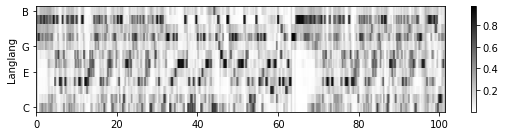

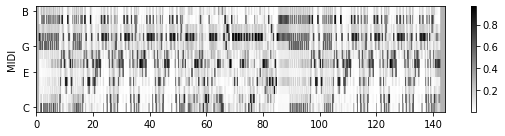

In [37]:
filt_len = 11
down_sampling = 2
C_smooth_dict = {}    
for name in fn_wav_dict:   
    C_smooth, Fs_C_smooth = smooth_downsample_feature_sequence(C_dict[name], Fs_C, 
                                        filt_len=filt_len, down_sampling=down_sampling)
    C_smooth_dict[name] = normalize_feature_sequence(C_smooth, norm='2', threshold=threshold)
    plot_chromagram(C_smooth_dict[name], Fs_C_smooth, figsize=figsize, 
                             ylabel=name, title='',  xlabel='', chroma_yticks=yticks)

## 중앙값 필터링(medain filtering)을 통한 스무딩

- local averaging 필터를 적용하는 것의 대안으로 **중앙값(median) 필터링**을 사용할 수 있다. 이 필터를 사용하면 날카로운 전환을 더 잘 보존하면서 약간의 평활화 효과도 얻을 수 있다. 유한한 숫자 목록의 **중앙값**은 숫자의 절반이 그값보다 낮고 절반이 그값보다 높은 속성을 가진 숫자 값이다. 중앙값은 가장 낮은 값에서 가장 높은 값으로 모든 숫자를 정렬하고 가운데 값을 선택하여 계산한다. 
- **중간값 필터링**의 아이디어는 시퀀스의 각 항목을 인접 항목의 **중간값**으로 바꾸는 것이다. 이웃의 크기는 적용된 중간 필터의 **길이**인 $L\in\mathbb{N}$ 파라미터에 의해 결정된다. feature 벡터 $x_n\in\mathbb{R}^K$의 시퀀스 $X=(x_1,x_2, ..., x_N)$가 주어지면, 각 $k\in[1:K]$에 대해 각 차원에 대한 중앙값 필터링을 적용합니다(평균 평활화에서 수행한 것과 동일).

* 다음 구현에서는 `scipy.signal.medfilt2d` 함수를 사용하여 2D 중앙값 필터링을 계산한다. 커널 크기 $1\times L$로 중앙값 필터링을 사용하면 대역별 1D 중앙값 필터링이 된다.
* `scipy.signal.medfilt2d`를 사용할 때 중간 필터 길이 $L$은 홀수여야 한다.
* 중앙값 필터링의 output array는 input array과 동일한 차원을 가진다. 경계 문제는 제로-패딩으로 처리된다.

In [38]:
X = np.array([[1, 2, 3, 4, 5], [5, 6, 7, 8, 9], [5, 3, 2, 8, 2]], dtype='float')
L = 3
filt_len = [1, L]
X_smooth = signal.medfilt2d(X, filt_len)
print('Input array X of dimension (K,N) with K=3 and N=5')
print(X)
print('Output array after median filtering with L=3')
print(X_smooth)

Input array X of dimension (K,N) with K=3 and N=5
[[1. 2. 3. 4. 5.]
 [5. 6. 7. 8. 9.]
 [5. 3. 2. 8. 2.]]
Output array after median filtering with L=3
[[1. 2. 3. 4. 4.]
 [5. 6. 7. 8. 8.]
 [3. 3. 3. 2. 2.]]


- 다음 그림은 원본 크로마그램과 평활화된 버전(한 번은 평균 필터링을 적용하고 한 번은 중앙값 필터링을 적용함)을 비교한다. 원래 크로마그램에서 음(note) 전환의 결과인 날카로운 edge를 관찰할 수 있다. 평균 평활화는 이러한 전환 사이에 번짐을 도입하지만 중앙값 평활화는 edge를 더 잘 보존하는 경향이 있다.

In [41]:
def median_downsample_feature_sequence(X, Fs, filt_len=41, down_sampling=10):
    """Smoothes and downsamples a feature sequence. Smoothing is achieved by median filtering
    
    Args:
        X (np.ndarray): Feature sequence
        Fs (scalar): Frame rate of ``X``
        filt_len (int): Length of smoothing filter (Default value = 41)
        down_sampling (int): Downsampling factor (Default value = 10)

    Returns:
        X_smooth (np.ndarray): Smoothed and downsampled feature sequence
        Fs_feature (scalar): Frame rate of ``X_smooth``
    """
    assert filt_len % 2 == 1  # L needs to be odd
    filt_len = [1, filt_len]
    X_smooth = signal.medfilt2d(X, filt_len)
    X_smooth = X_smooth[:, ::down_sampling]
    Fs_feature = Fs / down_sampling
    return X_smooth, Fs_feature

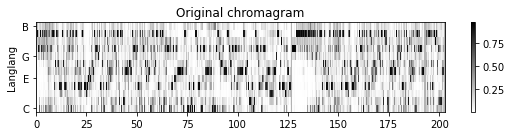

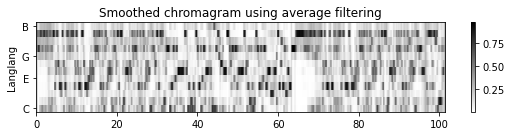

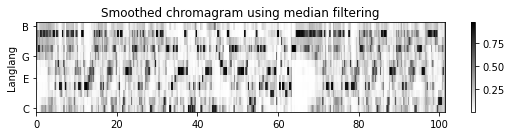

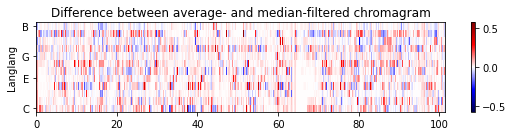

In [43]:
filt_len = 11
down_sampling = 2
C_median_dict = {}    
for name in fn_wav_dict:   
    C_median, Fs_C_smooth = median_downsample_feature_sequence(C_dict[name],  Fs_C,
                                                               filt_len=filt_len, down_sampling=down_sampling)
    C_median_dict[name] = normalize_feature_sequence(C_median, norm='2', threshold=threshold)

figsize=(8, 2)

name = 'Langlang'
plot_chromagram(C_dict[name], Fs_C_smooth, figsize=figsize, ylabel = name,
                         title='Original chromagram', xlabel='', chroma_yticks=yticks)
plot_chromagram(C_smooth_dict[name], Fs_C_smooth, figsize=figsize, ylabel = name,
                         title='Smoothed chromagram using average filtering', xlabel='', chroma_yticks=yticks) 
plot_chromagram(C_median_dict[name], Fs_C_smooth, figsize=figsize, ylabel = name, 
                         title='Smoothed chromagram using median filtering', xlabel='', chroma_yticks=yticks)  

C_diff = C_smooth_dict[name] - C_median_dict[name]
m = np.max(np.abs(C_diff))
plot_chromagram(C_diff, Fs_C_smooth, cmap='seismic', clim=[-m, m], figsize=figsize,
                         title='Difference between average- and median-filtered chromagram', xlabel='',
                         ylabel=name, chroma_yticks=yticks);

# 조옮김과 조율 (Transposition and Tuning)

## 조옮김 (Transposition)

- 음악에서는 종종 멜로디나 음악 전체를 다른 키로 전환하는 경우가 있다. 이러한 개념을 **조옮김(transposition)** 이라고 한다. 
- 이러한 수정은 주어진 곡의 피치 범위를 다른 악기나 가수에 적용하기 위해 종종 적용된다. 엄밀히 말하면, 조옮김은 일련의 음표를 일정한 간격으로 피치를 올리거나 내리는 과정을 말한다. 예를 들어 C-major 스케일의 음표를 4 반음 위로 이동하면 E-major 스케일이 된다.

- 크로마 레벨에서 음악적 조옮김을 쉽게 시뮬레이션할 수 있다. $[0:11]$ 세트로 식별한 12개의 크로마 값은 순환적으로 정렬되며, **순환 이동 연산자(cyclic shift operator)** $\rho:\mathbb{R}^{12} \to \mathbb{R}^{12}$의 정의와 연관된다.
- 크로마 벡터 $x=(x(0),x(1),\ldots,x(10),x(11))^\intercal\in\mathbb{R}^{12}$가 주어지면, cyclic shift operator를 다음과 같이 정의할 수 있다.
    - $\rho(x):=(x(11),x(0),x(1),\ldots,x(10))^\intercal$

- 즉, $x$의 크로마 밴드(chroma band) $\mathrm{C}$는 $\rho(x)$에서 크로마-밴드 $\mathrm{C}^\sharp$가, 그리고 $\mathrm{C}^\sharp$가, 그리고 $\mathrm{D}$가, 계속해서 마지막으로 $\mathrm{B}$는 $\mathrm{C}$가 된다
. 
- $i$의 순환 이동을 정의하는 $i\in\mathbb{N}$에 대해 $\rho^i:=\rho\circ\rho^{i-1}$를 얻기 위해 순환 이동 연산자를 연속적으로 적용할 수 있다. 반음 위로. 분명히 $\rho^{12}(x) = x$는 크로마 벡터를 12반음(1옥타브) 위로 주기적으로 이동하여 원래 벡터를 복구함을 의미합니다. 크로마그램의 모든 프레임에 순환 이동 연산자를 동시에 적용하면 전체 크로마그램이 수직 방향으로 순환 이동하게 됩니다. $\mathrm{C}$-메이저 스케일의 원래 크로마그램이 4반음 위로 이동된 다음 예에서 이를 확인할 수 있습니다. 그 결과 E-메이저 스케일 중 하나처럼 보이는 크로마그램이 생성됩니다.
네 반음의 조옮김.

- 순환 이동 연산자는 $\rho^i:=\rho\circ\rho^{i-1}$ for $i\in\mathbb{N}$와 같이 연속적으로 적용될 수 있다. 이는 $ㅑ$반음 위로 순환 이동함을 뜻한다.
- 물론 $\rho^{12}(x) = x$는 크로마 벡터를 12반음(1옥타브) 위로 순환적으로 이동하여 원래 벡터를 복구함을 의미한다.

- 크로마그램의 모든 프레임에 순환 이동 연산자를 동시에 적용하면 전체 크로마그램이 수직 방향으로 순환 이동하게 된다. $\mathrm{C}$-메이저 스케일의 원래 크로마그램이 4반음 위로 이동된 다음 예에서 이를 확인할 수 있다. 그 결과 4개의 반음이 조옮김된 E-major 음계 중 하나처럼 보이는 크로마그램이 생성된다.

In [44]:
def cyclic_shift(C, shift=1):
    """Cyclically shift a chromagram

    Args:
        C (np.ndarray): Chromagram
        shift (int): Tranposition shift (Default value = 1)

    Returns:
        C_shift (np.ndarray): Cyclically shifted chromagram
    """
    C_shift = np.roll(C, shift=shift, axis=0)
    return C_shift

(<Figure size 576x144 with 2 Axes>,
 [<AxesSubplot: title={'center': 'Chromagram of C-major scale cyclically shifted four semitones upwards'}, xlabel='Time (seconds)', ylabel='Chroma'>],
 <matplotlib.image.AxesImage at 0x1aa2ec4f3a0>)

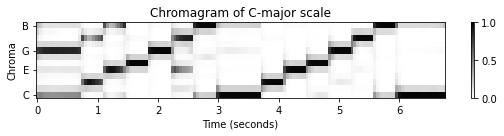

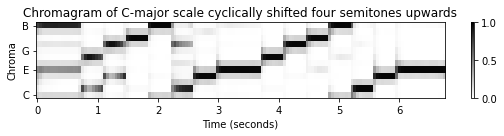

In [45]:
x_cmajor, Fs = librosa.load("../audio/piano_c_scale.wav")

N = 4096
H = 1024
figsize = (8, 2)
yticks = [0, 4, 7, 11]

C = librosa.feature.chroma_stft(y=x_cmajor, sr=Fs, tuning=0, norm=2, hop_length=H, n_fft=N)
title = 'Chromagram of C-major scale'
plot_chromagram(C, Fs/H, figsize=figsize, title=title, clim=[0, 1], chroma_yticks=yticks)

C = librosa.feature.chroma_stft(y=x_cmajor, sr=Fs, tuning=0, norm=2, hop_length=H, n_fft=N)
C_shift = cyclic_shift(C, shift=4)
title = 'Chromagram of C-major scale cyclically shifted four semitones upwards'
plot_chromagram(C_shift, Fs/H, figsize=figsize, title=title, clim=[0, 1], chroma_yticks=yticks)

#C = librosa.feature.chroma_stft(y=x_emajor, sr=Fs, tuning=0, norm=2, hop_length=H, n_fft=N)
#title = 'Chromagram of E-major scale'
#plot_chromagram(C, Fs/H, figsize=figsize, title=title, clim=[0, 1], chroma_yticks=yticks);

## 조율 (Tuning)

- 조옮김은 반음(semitone) 수준의 피치 이동이지만, 이제 sub-semitone 수준의 전체적 주파수 편차(global frequency deviations)에 대해 살펴보자. 이러한 편차는 중심 주파수가 $440~\mathrm{Hz}$인 예상 기준 피치 $\mathrm{A4}$보다 낮거나 높게 조율된 악기의 결과일 수 있다. 예를 들어, 많은 현대 오케스트라는 $440$Hz보다 약간 높은 튜닝 주파수를 사용하는 반면 바로크 음악을 연주하는 앙상블은 종종 $440$Hz보다 낮게 튜닝한다. 

- 튜닝 효과를 보상하려면 MIDI 피치의 중심 주파수를 조정하는 추가 튜닝 추정 단계와 피치 기반 로그 주파수 스펙트로그램을 계산하기 위한 로그 분할을 수행해야 한다.
- 보다 정확하게는 $\theta\in[-50,50)$(cent 단위)를 global tuning deviation이라고 하자. 그런 다음 조정된 중심 주파수의 공식은 다음과 같다.
    - $F^\theta_\mathrm{pitch}(p) = 2^{(p-69+\theta/100)/12} \cdot 440$
- 로그 분할의 조정은 크로마그램을 계산하기 위해 `librosa`-함수에 내장되어 있다.

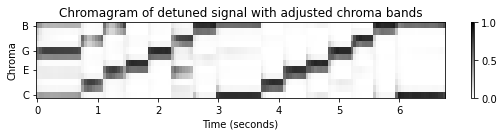

In [46]:
# detuned c_scale 음악 파일이 없기 때문에 기존의 c_scale을 detuned되어있다고 생각하고 tuning한다면 어떻게 되는지 살펴보자.

x, Fs = librosa.load("../audio/piano_c_scale.wav")
yticks = [0, 4, 7, 11]
N = 4096
H = 1024

theta = 40
tuning = theta / 100
C = librosa.feature.chroma_stft(y=x, sr=Fs, tuning=tuning, norm=2, hop_length=H, n_fft=N)
title = 'Chromagram of detuned signal with adjusted chroma bands'
plot_chromagram(C, Fs/H, figsize=figsize, title=title, clim=[0, 1], chroma_yticks=yticks);

## 튜닝 추정 (Tuning Estimation)

- 악기의 조율은 일반적으로 고정된 기준 피치를 기반으로 한다. 서양 음악에서는 일반적으로 주파수가 $440~\mathrm{Hz}$인 **concert 피치** $\mathrm{A4}$를 사용한다. 따라서 $\mathrm{A4}$ 음표를 연주하면 $440~\mathrm{Hz}$(기본 주파수(fundamental frequency)에 해당) 및 정수 배수(고조파(harmonics)에 해당) 근처에서 우세한 주파수를 기대할 수 있다.

- $x=(x(0), x(1), ..., x(N-1))$를 녹음된 음표 $\mathrm{A4}$의 샘플 신호(샘플링 속도 $F_\mathrm{s}$ 사용)라고 하자. 또한 $X = \mathrm{DFT}_N \cdot x$를 이산 푸리에 변환이라고 하자. 푸리에 계수 $X(k)$의 인덱스 $k\in[0:N-1]$는 헤르츠로 주어진 다음의 물리적 주파수(physical frequency)에 해당된다.
    - $F_\mathrm{coef}(k) := \frac{k\cdot F_\mathrm{s}}{N} $

- 한 가지 간단한 방법은 $440~\mathrm{Hz}$ 부근(예: 반음 더하기/빼기)에서 최대 크기 계수 $|X(k_0)|$를 생성하는 주파수 인덱스 $k_0$를 찾는 것이다.

- $ \log_2\left(\frac{F_\mathrm{coef}(k_0)}{440}\right) \cdot 1200 $는 튜닝 편차의 추정치를 산출한다(cent로). 보다 강력한 추정치를 얻기 위해 고조파의 적절히 정의된 이웃에서 스펙트럼 피크 위치를 고려할 수도 있다. 물론 다른 음도 튜닝 편차를 추정하기 위한 기준으로 사용될 수 있다.

- 일반적으로 전체 음악 녹음이 주어지면 하나의 음을 따로 연주한다고 가정할 수 없다. 다음에서는 녹음된 음악이 $12$ 톤의 평균율 음계를 기반으로 하지만 이상적인 조율에서 벗어날 가능성이 있는 시나리오를 고려해본다. 이 편차가 cent로 주어진 단일 파라미터 $\theta$로 표현될 수 있다고 가정한다. 
= 예를 들어, 이전에 사용된 디튜닝된 $\mathrm{C}$-메이저 스케일에서 $\theta=40$ 센트가 사용했다. 튜닝 추정의 목적은 이 파라미터 $\theta$를 결정하는 것입니다. 다음은 기본 절차를 설명한다.

1. 먼저 신호의 전체 주파수 분포를 계산한다. 함수 `compute_freq_distribution`에서 두 가지 옵션을 고려한다.
     * `Local=True`: 신호의 (로컬) 크기 STFT를 계산한 다음, 평균을 냄
     * `Local=False`: 전체 신호의 (전역) 크기 DFT를 계산
     
     
2. 크기(magnitude) DFT 또는 STFT를 계산할 때 로그 압축(compression)을 적용하여 작은 신호 구성 요소(예: `gamma=100`)를 향상시킨다.


3. 그런 다음 보간 기술(interpolation technique)을 사용하여 주파수 축(헤르츠로 주어짐)을 **로그 축**(1센트 해상도(resolution)의 센트 단위로 주어짐)으로 변환환다. 그 결과 신호의 주파수 분포를 나타내는 벡터 $v\in\mathbb{R}^M$가 생성된다.


4. 로컬 주파수 평균을 빼고, 결과를 수정(양수 부분만 고려)하여 이 벡터를 더 향상시킬 수 있다. `filt_len` 파라미터는 로컬 평균을 계산하는 데 사용되는 필터 길이(센트 단위)를 지정한다. 예를 들어 'filt_len=101'은 대략 1반음에 해당된다.


5. 다음 단계에서는 모든 튜닝 파라미터 $\theta\in \Theta$에 대해 **comb-like template vectors** $\mathbf{t}_\theta\in\mathbb{R}^M$(함수 `template_comb`로 계산됨)를 정의한다. 각 템플릿 $\mathbf{t}_\theta$는 기준 튜닝이 $\theta$ 센트 이동된 12-톤의 평균율 음계를 기반으로 이상적인 피치 그리드를 인코딩한다. $\Theta$ 집합은 고려해야 할 모든 가능한 튜닝 편차 집합을 나타낸다. 1센트 해상도에서 한 반음의 범위를 나타내는 $\Theta=[-50:49]=\{-50, -49, \ldots,-1, 0, 1, \ldots, 48, 49\}$를 사용할 수 있다.


6. 마지막으로, 적절한 유사성 척도를 사용하여 $v$를 $\mathbf{t}_\theta$ for all $\theta\in \Theta$와 비교한다. `tuning_similarity` 함수를 이용해, 이 비교를 위해 단순히 **내적(inner product)** $\langle v\mid\mathbf{t}_\theta\rangle$을 사용한다. 튜닝 파라미터는 **유사성 최대화 매개변수 (similarity-maximizing parameter)** $\theta_\mathrm{max}$로 다음과 같이 정의된다.
$$
\theta_\mathrm{max} = \mathrm{argmax}_{\theta\in\Theta}\langle v\mid\mathbf{t}_\theta\rangle
$$

In [57]:
def compute_freq_distribution(x, Fs, N=16384, gamma=100.0, local=True, filt=True, filt_len=101):
    """Compute an overall frequency distribution

    Args:
        x (np.ndarray): Signal
        Fs (scalar): Sampling rate
        N (int): Window size (Default value = 16384)
        gamma (float): Constant for logarithmic compression (Default value = 100.0)
        local (bool): Computes STFT and averages; otherwise computes global DFT (Default value = True)
        filt (bool): Applies local frequency averaging and by rectification (Default value = True)
        filt_len (int): Filter length for local frequency averaging (length given in cents) (Default value = 101)

    Returns:
        v (np.ndarray): Vector representing an overall frequency distribution
        F_coef_cents (np.ndarray): Frequency axis (given in cents)
    """
    if local:
        # Compute an STFT and sum over time
        if N > len(x)//2:
            raise Exception('The signal length (%d) should be twice as long as the window length (%d)' % (len(x), N))
        Y, T_coef, F_coef = stft_convention_fmp(x=x, Fs=Fs, N=N, H=N//2, mag=True, gamma=gamma)
        # Error "range() arg 3 must not be zero" occurs when N is too large. Why?
        Y = np.sum(Y, axis=1)
    else:
        # Compute a single DFT for the entire signal
        N = len(x)
        Y = np.abs(np.fft.fft(x)) / Fs
        Y = Y[:N//2+1]
        Y = np.log(1 + gamma * Y)
        # Y = libfmp.c3.log_compression(Y, gamma=100)
        F_coef = np.arange(N // 2 + 1).astype(float) * Fs / N

    # Convert linearly spaced frequency axis in logarithmic axis (given in cents)
    # The minimum frequency F_min corresponds 0 cents.
    f_pitch = lambda p: 440 * 2 ** ((p - 69) / 12)
    p_min = 24               # C1, MIDI pitch 24
    F_min = f_pitch(p_min)   # 32.70 Hz
    p_max = 108              # C8, MIDI pitch 108
    F_max = f_pitch(p_max)   # 4186.01 Hz
    F_coef_log, F_coef_cents = compute_f_coef_log(R=1, F_min=F_min, F_max=F_max)
    Y_int = interp1d(F_coef, Y, kind='cubic', fill_value='extrapolate')(F_coef_log)
    v = Y_int / np.max(Y_int)

    if filt:
        # Subtract local average and rectify
        filt_kernel = np.ones(filt_len)
        Y_smooth = signal.convolve(Y_int, filt_kernel, mode='same') / filt_len
        # Y_smooth = signal.medfilt(Y_int, filt_len)
        Y_rectified = Y_int - Y_smooth
        Y_rectified[Y_rectified < 0] = 0
        v = Y_rectified / np.max(Y_rectified)

    return v, F_coef_cents


def template_comb(M, theta=0):
    """Compute a comb template on a pitch axis

    Args:
        M (int): Length template (given in cents)
        theta (int): Shift parameter (given in cents); -50 <= theta < 50 (Default value = 0)

    Returns:
        template (np.ndarray): Comb template shifted by theta
    """
    template = np.zeros(M)
    peak_positions = (np.arange(0, M, 100) + theta)
    peak_positions = np.intersect1d(peak_positions, np.arange(M)).astype(int)
    template[peak_positions] = 1
    return template


def tuning_similarity(v):
    """Compute tuning similarity

    Args:
        v (np.ndarray): Vector representing an overall frequency distribution

    Returns:
        theta_axis (np.ndarray): Axis consisting of all tuning parameters -50 <= theta < 50
        sim (np.ndarray): Similarity values for all tuning parameters
        ind_max (int): Maximizing index
        theta_max (int): Maximizing tuning parameter
        template_max (np.ndarray): Similiarty-maximizing comb template
    """
    theta_axis = np.arange(-50, 50)  # Axis (given in cents)
    num_theta = len(theta_axis)
    sim = np.zeros(num_theta)
    M = len(v)
    for i in range(num_theta):
        theta = theta_axis[i]
        template = template_comb(M=M, theta=theta)
        sim[i] = np.inner(template, v)
    sim = sim / np.max(sim)
    ind_max = np.argmax(sim)
    theta_max = theta_axis[ind_max]
    template_max = template_comb(M=M, theta=theta_max)
    return theta_axis, sim, ind_max, theta_max, template_max

In [58]:
x, Fs = librosa.load("../audio/piano_c_scale.wav")

v, F_coef_cents = compute_freq_distribution(x, Fs=Fs, N=16384, gamma=10, 
                                            local=True, filt_len=101)
theta_axis, sim, ind_max, theta_max, template_max = tuning_similarity(v)

print('Estimated tuning: %d cents' % theta_max)

Estimated tuning: 7 cents


### parameter dependency

- 이 튜닝 추정이 작동하는 방법을 잘 이해하기 위해 $\theta\in\Theta=[-50:49]$에 대한 함수로 $v$와 $\mathbf{t}_\theta$ 사이의 유사성을 시각화해보자(`plot_tuning_similarity` 기능 사용). 또한 유사성 최대화 템플릿(`plot_freq_vector_template` 함수 사용)과 함께 주파수 벡터를 그려보자. 

In [59]:
def plot_tuning_similarity(sim, theta_axis, theta_max, ax=None, title=None, figsize=(4, 3)):
    """Plots tuning similarity

    Args:
        sim: Similarity values
        theta_axis: Axis consisting of cent values [-50:49]
        theta_max: Maximizing tuning parameter
        ax: Axis (in case of ax=None, figure is generated) (Default value = None)
        title: Title of figure (or subplot) (Default value = None)
        figsize: Size of figure (only used when ax=None) (Default value = (4, 3))

    Returns:
        fig: Handle for figure
        ax: Handle for axes
        line: handle for line plot
    """
    fig = None
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = plt.subplot(1, 1, 1)
    if title is None:
        title = 'Estimated tuning: %d cents' % theta_max
    line = ax.plot(theta_axis, sim, 'k')
    ax.set_xlim([theta_axis[0], theta_axis[-1]])
    ax.set_ylim([0, 1.1])
    ax.plot([theta_max, theta_max], [0, 1.1], 'r')
    ax.set_xlabel('Tuning parameter (cents)')
    ax.set_ylabel('Similarity')
    ax.set_title(title)
    if fig is not None:
        plt.tight_layout()
    return fig, ax, line


def plot_freq_vector_template(v, F_coef_cents, template_max, theta_max, ax=None, title=None, figsize=(8, 3)):
    """Plots frequency distribution and similarity-maximizing template

    Args:
        v: Vector representing an overall frequency distribution
        F_coef_cents: Frequency axis
        template_max: Similarity-maximizing template
        theta_max: Maximizing tuning parameter
        ax: Axis (in case of ax=None, figure is generated) (Default value = None)
        title: Title of figure (or subplot) (Default value = None)
        figsize: Size of figure (only used when ax=None) (Default value = (8, 3))

    Returns:
        fig: Handle for figure
        ax: Handle for axes
        line: handle for line plot
    """
    fig = None
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = plt.subplot(1, 1, 1)
    if title is None:
        title = r'Frequency distribution with maximizing comb template ($\theta$ = %d cents)' % theta_max
    line = ax.plot(F_coef_cents, v, c='k', linewidth=1)
    ax.set_xlim([F_coef_cents[0], F_coef_cents[-1]])
    ax.set_ylim([0, 1.1])
    x_ticks_freq = np.array([0, 1200, 2400, 3600, 4800, 6000, 7200, 8000])
    ax.plot(F_coef_cents, template_max * 1.1, 'r:', linewidth=0.5)
    ax.set_xticks(x_ticks_freq)
    ax.set_xlabel('Frequency (cents)')
    plt.title(title)
    if fig is not None:
        plt.tight_layout()
    return fig, ax, line

Average STFT (Local=True), without enhancement (Filt=False):


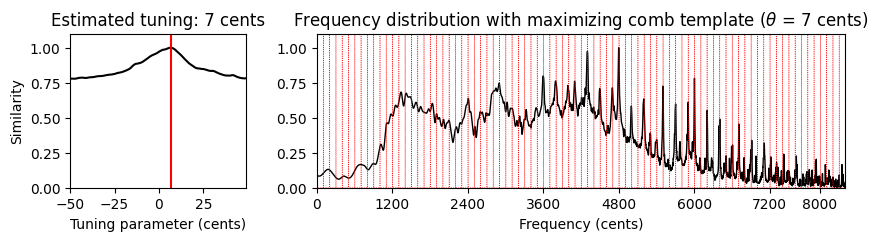

Average STFT (Local=True), with enhancement (Filt=True):


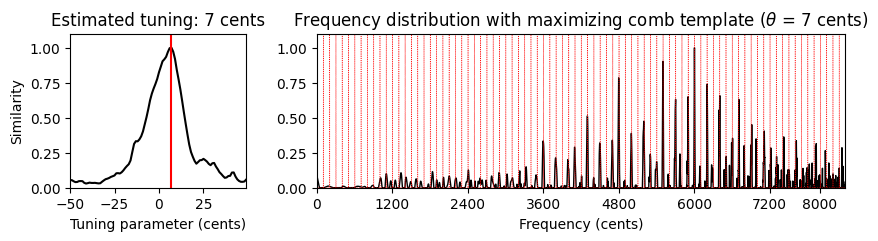

Global DFT (Local=False), with enhancement (Filt=True):


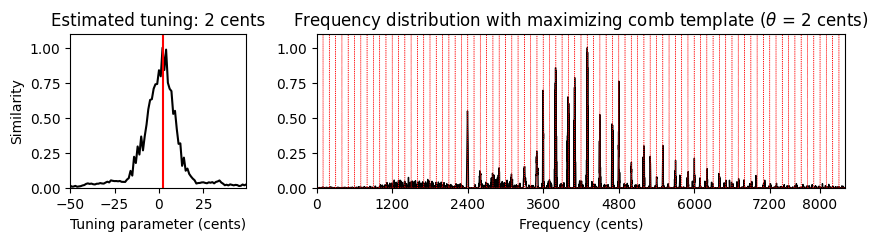

In [61]:
# Load audio signal
x, Fs = librosa.load("../audio/piano_c_scale.wav")

print('Average STFT (Local=True), without enhancement (Filt=False):', flush=True)
v, F_coef_cents = compute_freq_distribution(x, Fs=Fs, N=16384, gamma=10, 
                                            local=True, filt=False)
theta_axis, sim, ind_max, theta_max, template_max = tuning_similarity(v)
fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 3], 
                                          'height_ratios': [1]}, figsize=(10, 2))
plot_tuning_similarity(sim, theta_axis, theta_max, ax=ax[0])
plot_freq_vector_template(v, F_coef_cents, template_max, theta_max, ax=ax[1])
plt.show()

print('Average STFT (Local=True), with enhancement (Filt=True):', flush=True)
v, F_coef_cents = compute_freq_distribution(x, Fs=Fs, N=16384, gamma=10, 
                                            local=True, filt_len=101)
theta_axis, sim, ind_max, theta_max, template_max = tuning_similarity(v)
fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 3], 
                                          'height_ratios': [1]}, figsize=(10, 2))
plot_tuning_similarity(sim, theta_axis, theta_max, ax=ax[0])
plot_freq_vector_template(v, F_coef_cents, template_max, theta_max, ax=ax[1])
plt.show()

print('Global DFT (Local=False), with enhancement (Filt=True):', flush=True)
v, F_coef_cents = compute_freq_distribution(x, Fs=Fs, N=16384, gamma=10, 
                                            local=False, filt_len=101)
theta_axis, sim, ind_max, theta_max, template_max = tuning_similarity(v)
fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 3], 
                                          'height_ratios': [1]}, figsize=(10, 2))
plot_tuning_similarity(sim, theta_axis, theta_max, ax=ax[0])
plot_freq_vector_template(v, F_coef_cents, template_max, theta_max, ax=ax[1])
plt.show()

Audio example: Cmaj


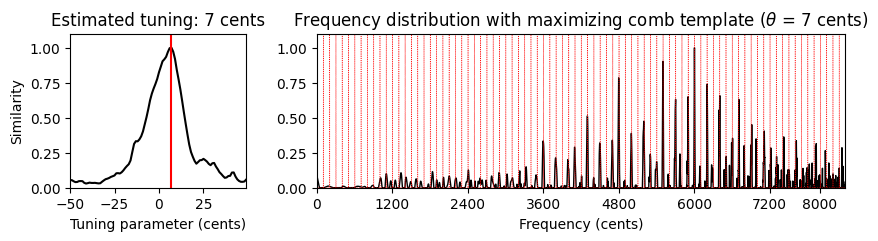

Audio example: C4piano


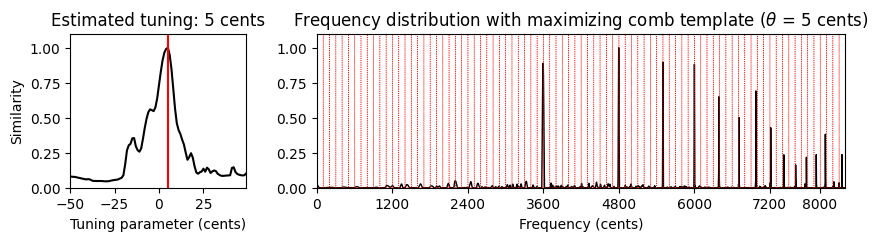

Audio example: prelude


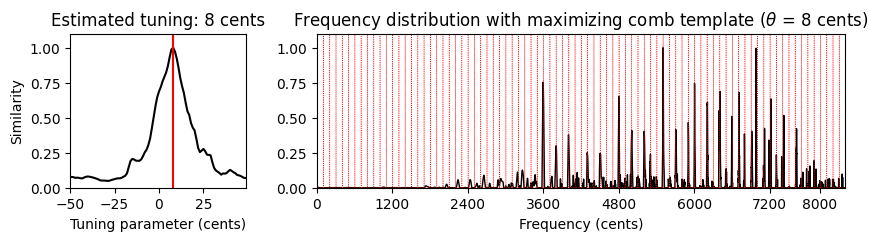

Audio example: C4violin


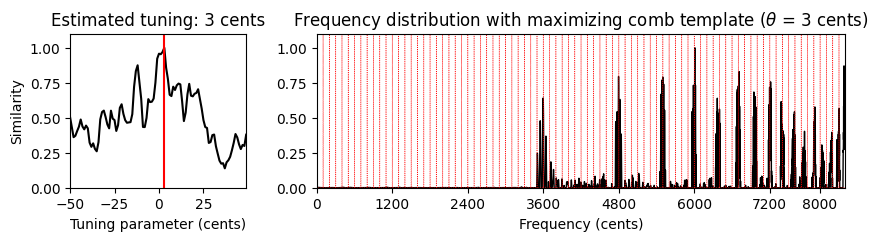

In [66]:
# 음악 예

fn_wav_dict = {}
fn_wav_dict['Cmaj'] = "../audio/piano_c_scale.wav"
fn_wav_dict['C4piano'] = "../audio/piano_c4.wav"
fn_wav_dict['prelude'] = "../audio/prelude_cmaj.wav"
fn_wav_dict['C4violin'] = "../audio/violin_c4.wav"

for name in fn_wav_dict:
    fn_wav = fn_wav_dict[name]
    x, Fs = librosa.load(fn_wav)
    print('Audio example: %s' % name)
    ipd.display(ipd.Audio(x, rate=Fs) )
    v, F_coef_cents = compute_freq_distribution(x, Fs=Fs, N=16384, gamma=10, 
                                                local=True, filt_len=101)
    theta_axis, sim, ind_max, theta_max, template_max = tuning_similarity(v)
    fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 3], 
                                              'height_ratios': [1]}, figsize=(10, 2))
    plot_tuning_similarity(sim, theta_axis, theta_max, ax=ax[0])
    #title=r'Frequency distribution with maximizing comb template'
    title = None
    plot_freq_vector_template(v, F_coef_cents, template_max, theta_max, ax=ax[1],  title=title)
    plt.show()

- 튜닝 추정의 또 다른 중요한 측면은 고려되는 주파수 범위이다. 12톤 음계에 따라 완벽하게 튜닝된 음악 녹음을 고려할 때에도 튜닝된 피치의 고조파는 평균율 그리드에서 상당한 편차를 유발할 수 있다.
- 또한 피아노와 같은 특정 악기의 경우 string stiffness로 인한 **부조화 (inharmonicities)** 로 인해 높은 고조파가 늘어나는 경향이 있다. 따라서 상위 주파수 스펙트럼이 너무 큰 역할을 할 때, 튜닝 추정치를 약간 증가시킬 수 있다. 
- 마지막으로 특정 주파수 범위가 튜닝 추정에 도움이 될 수 있는 음악적 이유가 있다. 예를 들어 Weber 오페라 녹음에서 가수의 강한 비브라토 및 여타 피치 변동의 존재는 튜닝 추정을 흐릿하고 불안정하게 만든다. 특히 소프라노 가수의 상위 주파수 대역이 문제가 되기도 한다.